In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.metrics import precision_score


2024-03-18 20:37:40.946084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 20:37:41.822938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Read data from Excel file
data = pd.read_excel('operation_dataset.xlsx')

# Initialize lists to store features and labels
feature_list = []
label_list = []

# Iterate over all files in the given source path
print('Preparing feature dataset and labels.')
for index, row in tqdm(data.iterrows(), total=len(data)):
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('./operaciones', row['file'])
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    
    # Calculate features
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    
    # Append features and labels to lists
    feature_list.append(mels_db)
    label_list.append(row['result'])

# Determine the maximum length of the second dimension among all features
max_length = max(feature.shape[1] for feature in feature_list)

# Pad or truncate each feature to have the same length as max_length
for i, feature in enumerate(feature_list):
    pad_width = max_length - feature.shape[1]
    # Pad or truncate along the second dimension
    if pad_width > 0:
        feature_list[i] = np.pad(feature, ((0, 0), (0, pad_width)), mode='constant')
    elif pad_width < 0:
        feature_list[i] = feature[:, :max_length]

# Now, all features have the same shape, so you can reshape them
feature_list = [feature.reshape((128, -1, 1)) for feature in feature_list]

# Convert feature_list and label_list to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 2112/2112 [01:24<00:00, 24.97it/s]


In [3]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(18, activation=keras.activations.softmax)
    ])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 94, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 47, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 23552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23552)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,507,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,513,362 (5.77 MB)

 Trainable params: 1,513,362 (5.77 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
len(labels)

2112

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.1058 - loss: 17.5905 - val_accuracy: 0.2399 - val_loss: 1.7700
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.2487 - loss: 1.5828 - val_accuracy: 0.3682 - val_loss: 1.1115
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.4720 - loss: 0.8769 - val_accuracy: 0.5000 - val_loss: 0.7311
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5335 - loss: 1.2277 - val_accuracy: 0.0777 - val_loss: 36.3427
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.0980 - loss: 146.6993 - val_accuracy: 0.0709 - val_loss: 730.0986
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.0768 - loss: 1729.4943 - val_accuracy: 0.0439 - val_loss: 6261.0649
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.1063 - loss: 5890.0977 - val_accuracy: 0.0439 - val_loss: 14146.6094
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.1041 - loss: 17630.

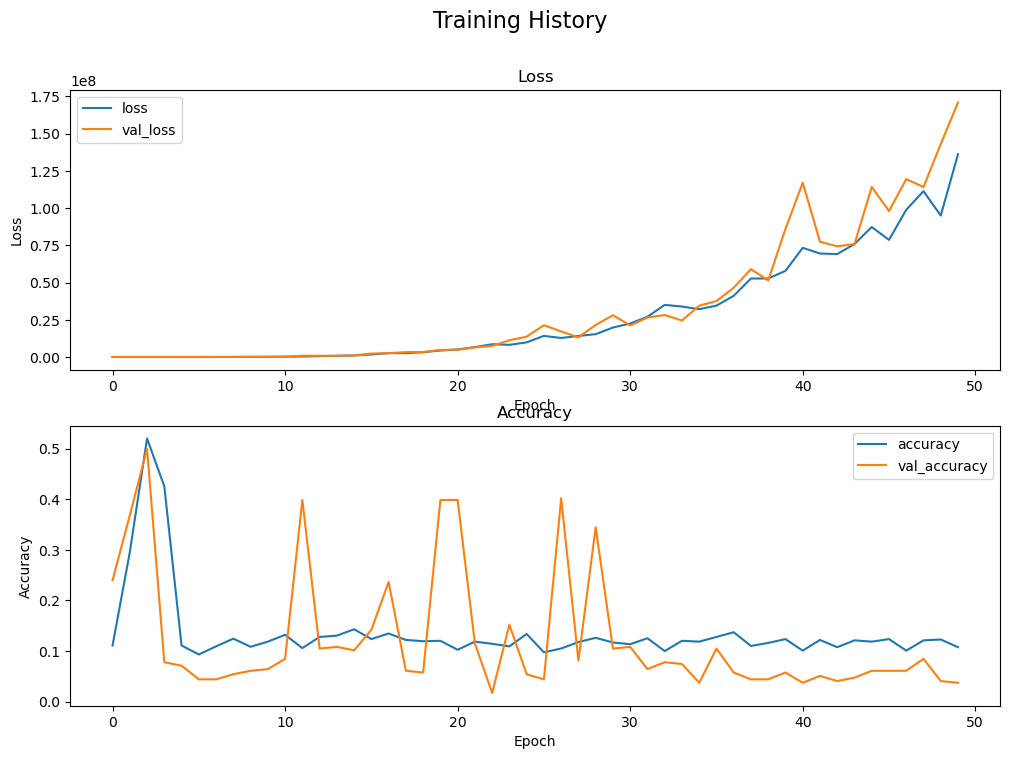

In [5]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 32
EPOCHS = 50

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=18)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
history = model.fit(x=X_train, y=y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()



In [6]:
# Evaluate the model (optional)
from sklearn.metrics import accuracy_score, precision_score, recall_score
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_test_class = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, average='macro')
recall = recall_score(y_test_class, y_pred_class, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 0.055205047318611984
Precision: 0.004600420609884332
Recall: 0.08333333333333333


In [7]:
model.save('cnn_model.keras')